<a href="https://colab.research.google.com/github/aashish-thapa/Parkinsons-Disease-Detection-from-Voice-Recording/blob/main/ParkinsonsDiseaseDetectionFromVoiceRecording.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data')
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset directly: {e}")
    print("Please try downloading 'parkinsons.data' from https://archive.ics.uci.edu/dataset/174/parkinsons manually and upload it to your Colab environment.")
    print("Then, you can load it using: df = pd.read_csv('parkinsons.data')")

if 'df' in locals():
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    print("\nDataset Info:")
    df.info()

    print("\nDescriptive Statistics:")
    print(df.describe())

Dataset loaded successfully!

First 5 rows of the dataset:
             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR    

## Data Preprocessing


Dataset after dropping 'name' column:
   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0      119.992       157.302        74.997         0.00784           0.00007   
1      122.400       148.650       113.819         0.00968           0.00008   
2      116.682       131.111       111.555         0.01050           0.00009   
3      116.676       137.871       111.366         0.00997           0.00009   
4      116.014       141.781       110.655         0.01284           0.00011   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0   0.00370   0.00554     0.01109       0.04374             0.426  ...   
1   0.00465   0.00696     0.01394       0.06134             0.626  ...   
2   0.00544   0.00781     0.01633       0.05233             0.482  ...   
3   0.00502   0.00698     0.01505       0.05492             0.517  ...   
4   0.00655   0.00908     0.01966       0.06425             0.584  ...   

   Shimmer:DDA      NHR     HNR  st

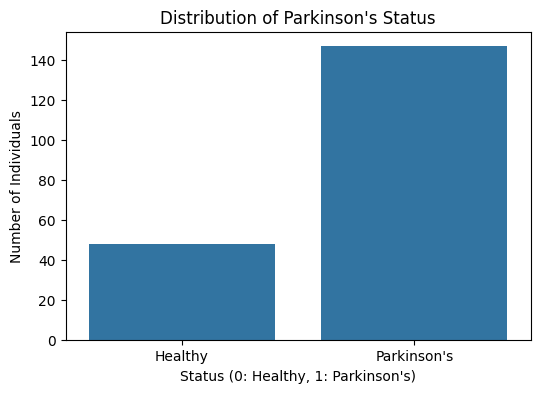

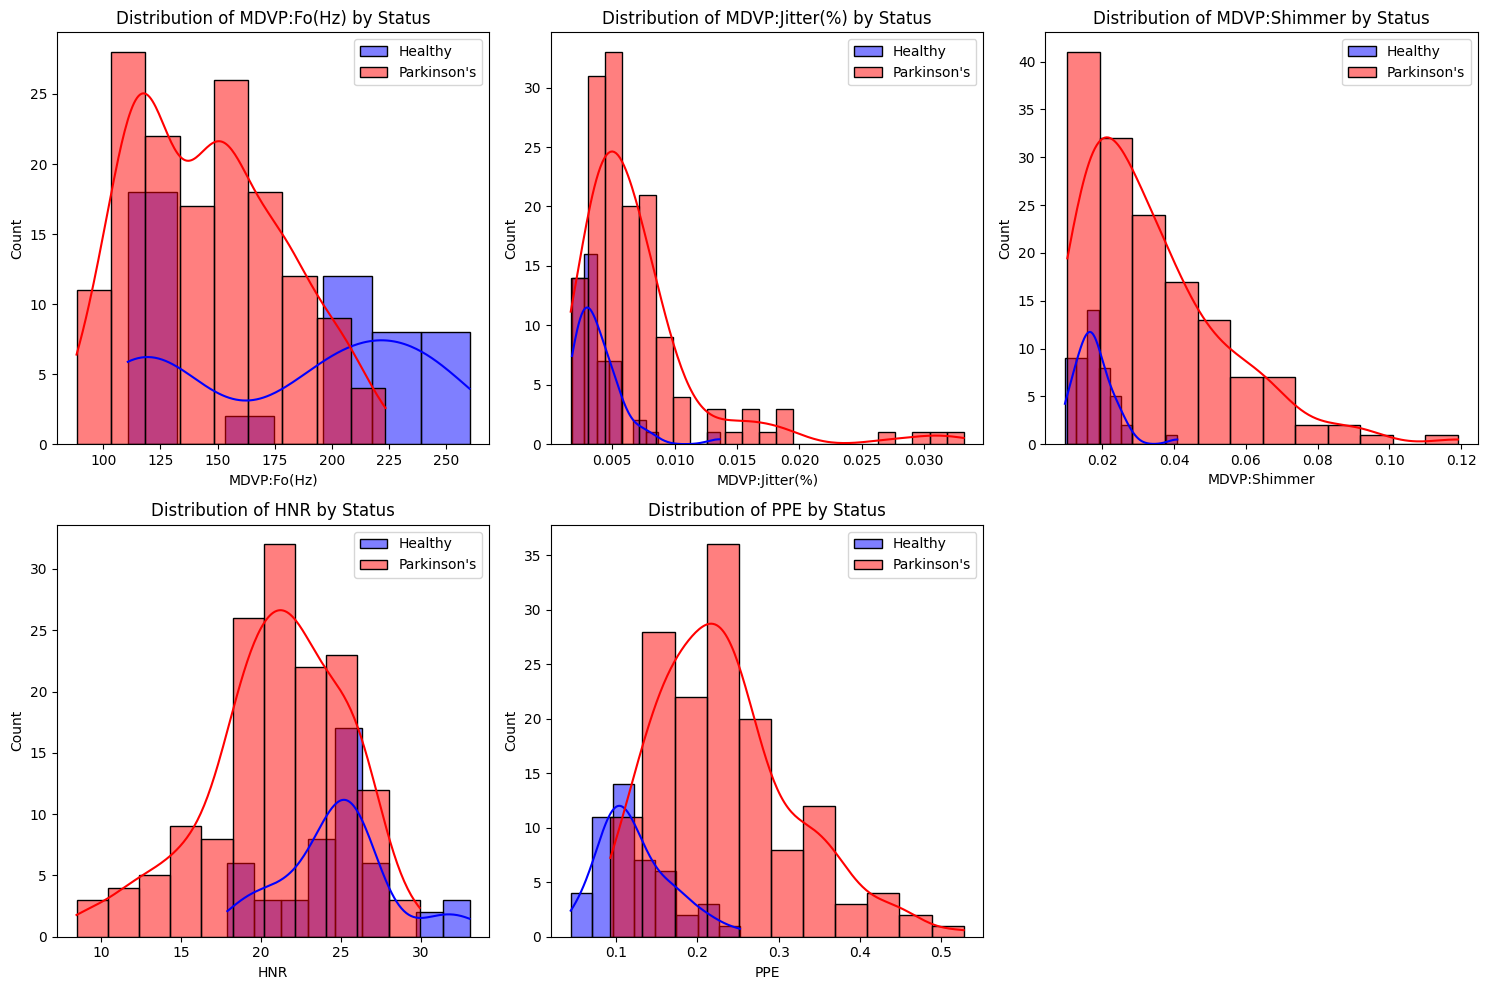

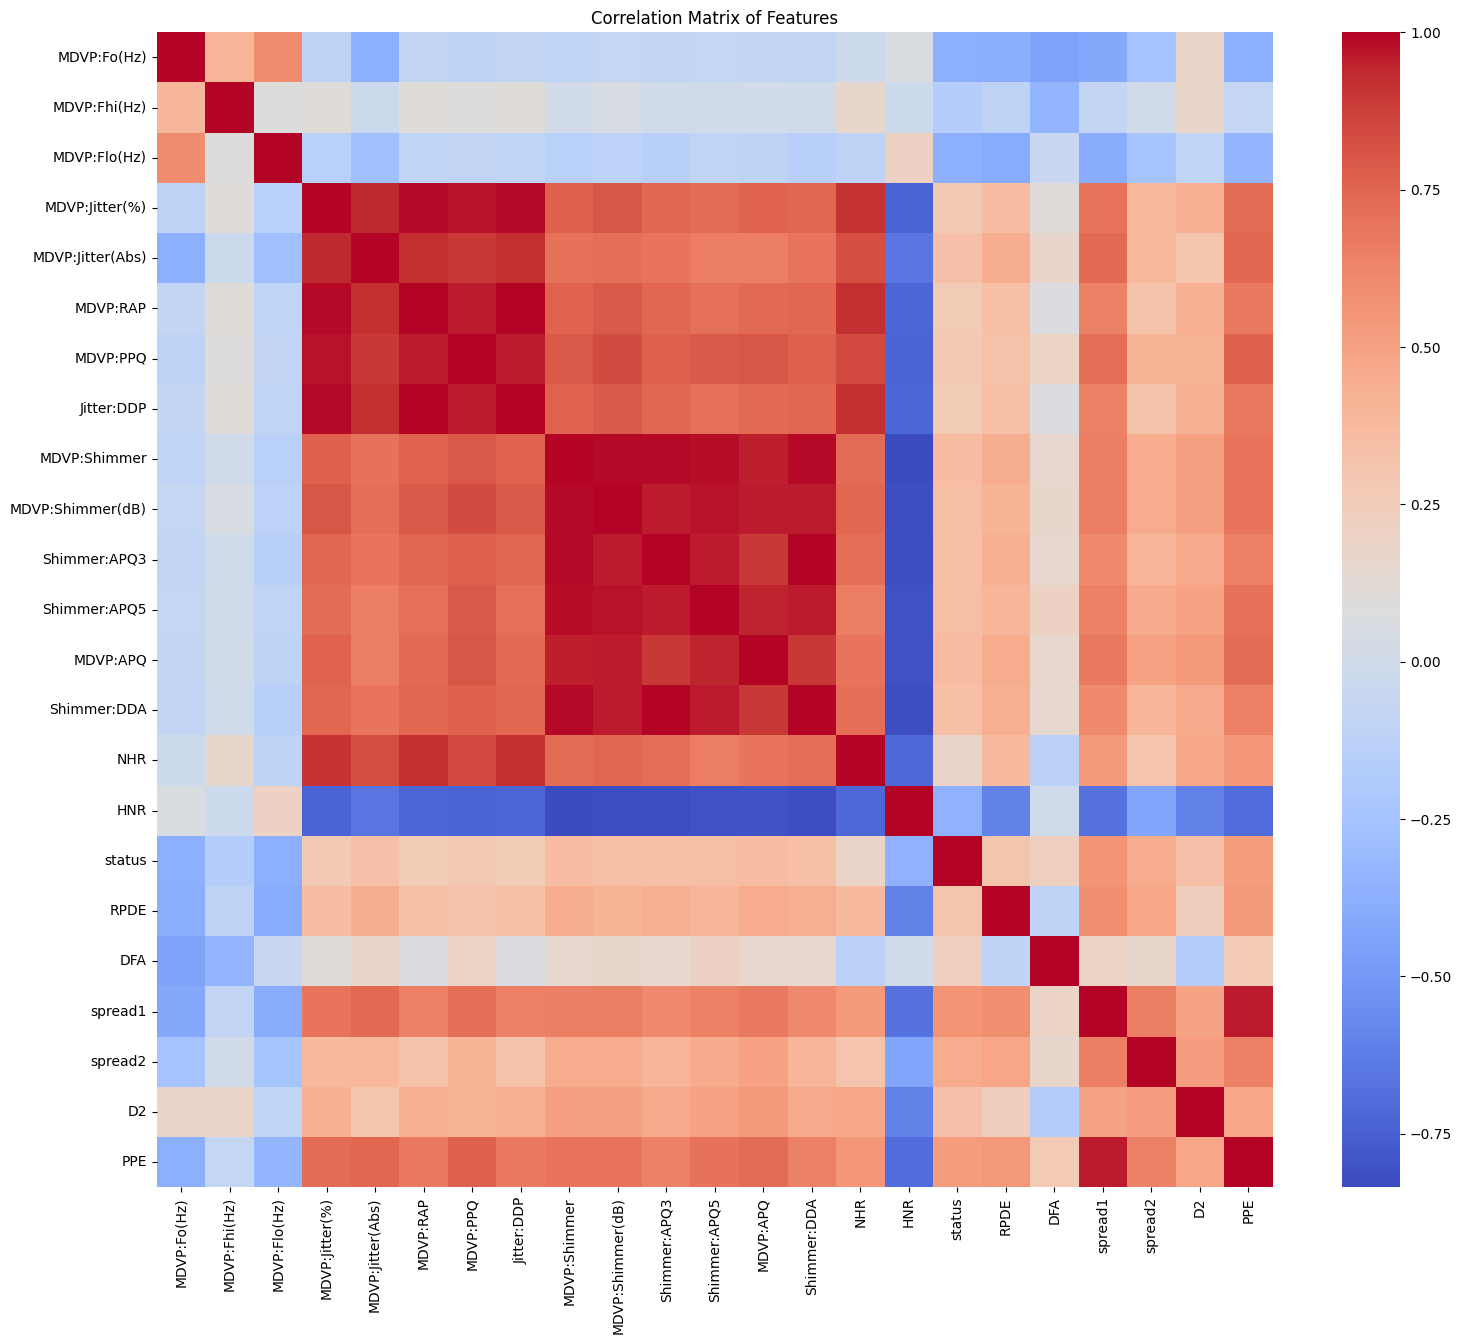


Correlation of features with 'status':
status              1.000000
spread1             0.564838
PPE                 0.531039
spread2             0.454842
MDVP:Shimmer        0.367430
MDVP:APQ            0.364316
Shimmer:APQ5        0.351148
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ3        0.347617
Shimmer:DDA         0.347608
D2                  0.340232
MDVP:Jitter(Abs)    0.338653
RPDE                0.308567
MDVP:PPQ            0.288698
MDVP:Jitter(%)      0.278220
MDVP:RAP            0.266668
Jitter:DDP          0.266646
DFA                 0.231739
NHR                 0.189429
MDVP:Fhi(Hz)       -0.166136
HNR                -0.361515
MDVP:Flo(Hz)       -0.380200
MDVP:Fo(Hz)        -0.383535
Name: status, dtype: float64


In [10]:

df_eda = df.copy()
df_eda = df_eda.drop('name', axis=1)

print("\nDataset after dropping 'name' column:")
print(df_eda.head())

print("\nMissing values per column:")
print(df_eda.isnull().sum())

print("\nDistribution of 'status' (0: Healthy, 1: Parkinson's):")
print(df_eda['status'].value_counts())
print("\nPercentage distribution of 'status':")
print(df_eda['status'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x='status', data=df_eda)
plt.title('Distribution of Parkinson\'s Status')
plt.xlabel('Status (0: Healthy, 1: Parkinson\'s)')
plt.ylabel('Number of Individuals')
plt.xticks([0, 1], ['Healthy', 'Parkinson\'s'])
plt.show()

features_to_plot = ['MDVP:Fo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Shimmer', 'HNR', 'PPE']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_eda[df_eda['status'] == 0][feature], color='blue', label='Healthy', kde=True)
    sns.histplot(df_eda[df_eda['status'] == 1][feature], color='red', label='Parkinson\'s', kde=True)
    plt.title(f'Distribution of {feature} by Status')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 15))
sns.heatmap(df_eda.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

print("\nCorrelation of features with 'status':")
print(df_eda.corr()['status'].sort_values(ascending=False))

## Train Test Split

In [11]:
X = df.drop(['name', 'status'], axis=1)
y = df['status']

print("\nShape of X (features):", X.shape)
print("Shape of y (target):", y.shape)


scaler = StandardScaler()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData after scaling (first 5 rows of X_train_scaled):")
print(X_train_scaled[:5])
print("\nData after scaling (first 5 rows of X_test_scaled):")
print(X_test_scaled[:5])


Shape of X (features): (195, 22)
Shape of y (target): (195,)

Shape of X_train: (156, 22)
Shape of X_test: (39, 22)
Shape of y_train: (156,)
Shape of y_test: (39,)

Data after scaling (first 5 rows of X_train_scaled):
[[-1.06344643 -0.9157626  -0.33580464 -0.55736615 -0.42216914 -0.54572802
  -0.53371905 -0.5457972  -0.80761002 -0.78182843 -0.81778696 -0.72094174
  -0.68559265 -0.81810818 -0.50697921  1.05569199 -1.27819709  1.0411946
  -0.37859861 -0.42503608 -1.26010198 -0.39131778]
 [ 0.58342091  0.12149404 -0.93052313  0.19156775 -0.150364    0.22668457
   0.20738945  0.22659085  0.84954945  0.67225948  0.9755243   0.92109609
   0.53691262  0.97553705  0.63813485 -1.68978323  0.54036702  0.19346526
   0.36289997  1.44380997  1.76000577  0.35952829]
 [-1.07057001 -0.75769779 -0.20592359 -0.29303654 -0.150364   -0.31525007
  -0.14632142 -0.31636473  0.51571515  0.40262729  0.55630868  0.58032569
   0.43032115  0.55662649 -0.03007556 -0.86247482  1.48100262 -0.22335502
   0.32128826 

## Model Training and Evaluation

--- Training Support Vector Machine (SVM) ---
SVM Accuracy: 0.9231
SVM Precision: 0.9062
SVM Recall: 1.0000
SVM F1-Score: 0.9508
SVM ROC AUC: 0.9552
Confusion Matrix for SVM:
[[ 7  3]
 [ 0 29]]
--------------------------------------------------
--- Training Random Forest Classifier ---
Random Forest Accuracy: 0.9231
Random Forest Precision: 0.9333
Random Forest Recall: 0.9655
Random Forest F1-Score: 0.9492
Random Forest ROC AUC: 0.9621
Confusion Matrix for Random Forest:
[[ 8  2]
 [ 1 28]]
--------------------------------------------------
--- Training Gradient Boosting Classifier ---
Gradient Boosting Accuracy: 0.9231
Gradient Boosting Precision: 0.9643
Gradient Boosting Recall: 0.9310
Gradient Boosting F1-Score: 0.9474
Gradient Boosting ROC AUC: 0.9690
Confusion Matrix for Gradient Boosting:
[[ 9  1]
 [ 2 27]]
--------------------------------------------------
--- Training Neural Network (MLPClassifier) ---
Neural Network Accuracy: 0.8462
Neural Network Precision: 0.8710
Neural Netwo

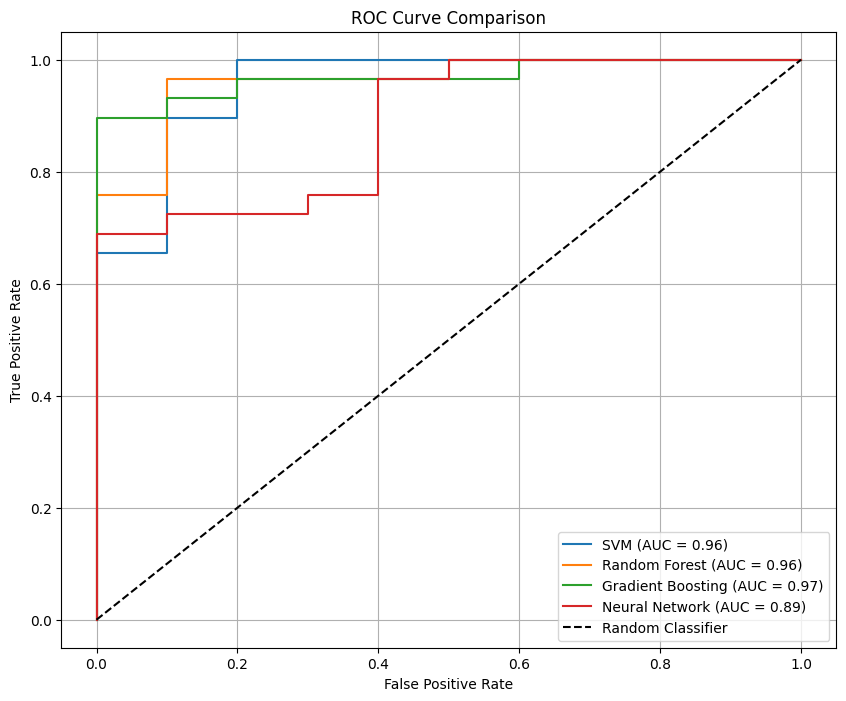

In [12]:
model_performance = {}

print("--- Training Support Vector Machine (SVM) ---")
svm_model = SVC(random_state=42, probability=True) # probability=True for ROC AUC
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1] # Probability of class 1

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)

model_performance['SVM'] = {
    'Accuracy': accuracy_svm,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1-Score': f1_svm,
    'ROC AUC': roc_auc_svm
}

print(f"SVM Accuracy: {accuracy_svm:.4f}")
print(f"SVM Precision: {precision_svm:.4f}")
print(f"SVM Recall: {recall_svm:.4f}")
print(f"SVM F1-Score: {f1_svm:.4f}")
print(f"SVM ROC AUC: {roc_auc_svm:.4f}")
print("Confusion Matrix for SVM:")
print(confusion_matrix(y_test, y_pred_svm))
print("-" * 50)

print("--- Training Random Forest Classifier ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

model_performance['Random Forest'] = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf,
    'ROC AUC': roc_auc_rf
}

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest Recall: {recall_rf:.4f}")
print(f"Random Forest F1-Score: {f1_rf:.4f}")
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print("-" * 50)


print("--- Training Gradient Boosting Classifier ---")
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
y_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate Gradient Boosting
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_proba_gb)

model_performance['Gradient Boosting'] = {
    'Accuracy': accuracy_gb,
    'Precision': precision_gb,
    'Recall': recall_gb,
    'F1-Score': f1_gb,
    'ROC AUC': roc_auc_gb
}

print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")
print(f"Gradient Boosting Precision: {precision_gb:.4f}")
print(f"Gradient Boosting Recall: {recall_gb:.4f}")
print(f"Gradient Boosting F1-Score: {f1_gb:.4f}")
print(f"Gradient Boosting ROC AUC: {roc_auc_gb:.4f}")
print("Confusion Matrix for Gradient Boosting:")
print(confusion_matrix(y_test, y_pred_gb))
print("-" * 50)


print("--- Training Neural Network (MLPClassifier) ---")
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True, validation_fraction=0.1)
nn_model.fit(X_train_scaled, y_train)
y_pred_nn = nn_model.predict(X_test_scaled)
y_proba_nn = nn_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate Neural Network
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, y_proba_nn)

model_performance['Neural Network'] = {
    'Accuracy': accuracy_nn,
    'Precision': precision_nn,
    'Recall': recall_nn,
    'F1-Score': f1_nn,
    'ROC AUC': roc_auc_nn
}

print(f"Neural Network Accuracy: {accuracy_nn:.4f}")
print(f"Neural Network Precision: {precision_nn:.4f}")
print(f"Neural Network Recall: {recall_nn:.4f}")
print(f"Neural Network F1-Score: {f1_nn:.4f}")
print(f"Neural Network ROC AUC: {roc_auc_nn:.4f}")
print("Confusion Matrix for Neural Network:")
print(confusion_matrix(y_test, y_pred_nn))
print("-" * 50)


# --- Compare Model Performance ---
print("\n--- Model Performance Comparison ---")
performance_df = pd.DataFrame(model_performance).T
print(performance_df.sort_values(by='ROC AUC', ascending=False))

# --- Plotting ROC Curves ---
plt.figure(figsize=(10, 8))
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)

plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


## Hyperparameter Tuning with GridSearchCV


--- Hyperparameter Tuning for Gradient Boosting (using GridSearchCV) ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Gradient Boosting: {'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 300}
Best ROC AUC score for Gradient Boosting: 0.9752

--- Hyperparameter Tuning for Random Forest (using GridSearchCV) ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for Random Forest: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best ROC AUC score for Random Forest: 0.9616

--- Final Evaluation of Tuned Models on Test Set ---
Tuned Gradient Boosting Test Accuracy: 1.0000
Tuned Gradient Boosting Test Precision: 1.0000
Tuned Gradient Boosting Test Recall: 1.0000
Tuned Gradient Boosting Test F1-Score: 1.0000
Tuned Gradient Boosting Test ROC AUC: 1.0000
Confusion Matrix for Tuned Gradient Boosting:
[[10  0]
 [ 0 29]]
-----------------------------------------

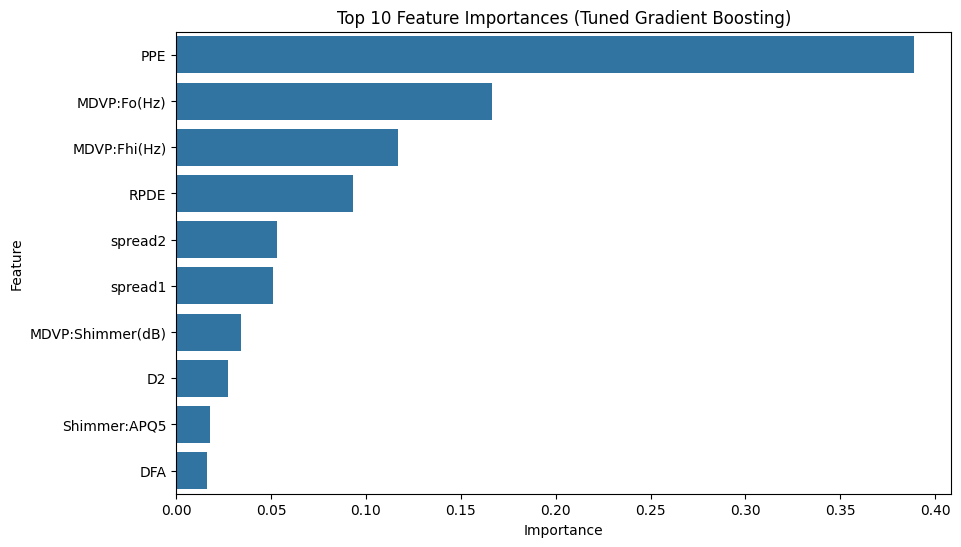


--- Feature Importance for Tuned Random Forest Classifier ---
             Feature  Importance
21               PPE    0.151209
18           spread1    0.108965
0        MDVP:Fo(Hz)    0.079289
19           spread2    0.065985
2       MDVP:Flo(Hz)    0.063728
1       MDVP:Fhi(Hz)    0.050227
7         Jitter:DDP    0.044271
14               NHR    0.042099
4   MDVP:Jitter(Abs)    0.039743
11      Shimmer:APQ5    0.039419


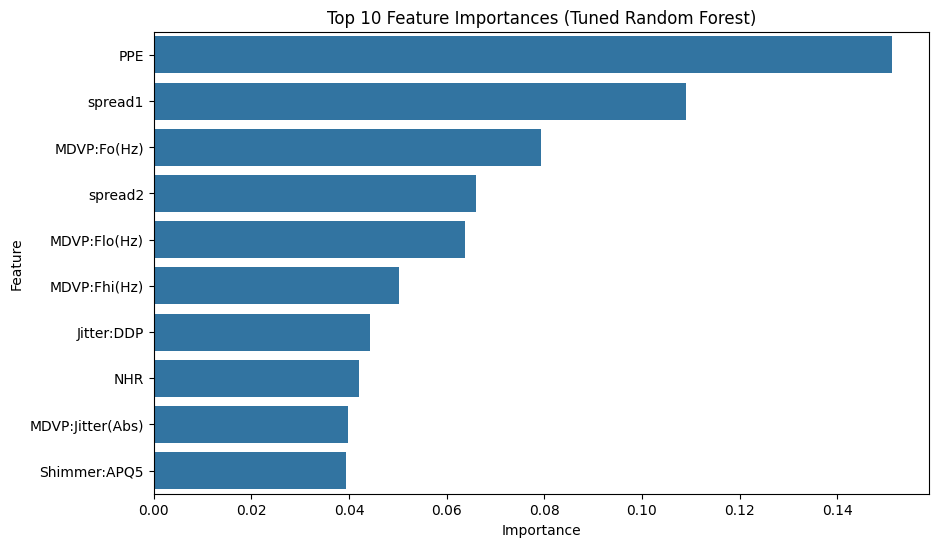


--- Addressing Imbalance (Brief Discussion) ---
While `stratify=y` during train-test split helps, for more severe imbalances, techniques like SMOTE could be considered.
Example of applying SMOTE (run *before* scaling and splitting for training set):
 from imblearn.over_sampling import SMOTE
 smote = SMOTE(random_state=42)
 X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
 Then scale X_resampled before training.


In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# function to evaluate models with cross-validation
def evaluate_model_cv(model, X, y, model_name):
    print(f"\n--- Evaluating {model_name} with Stratified K-Fold Cross-Validation ---")
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = {
        'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'ROC AUC': []
    }

    for fold, (train_index, val_index) in enumerate(cv_splitter.split(X, y)):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Apply scaling within each fold to prevent data leakage from validation set
        scaler_fold = StandardScaler()
        X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler_fold.transform(X_val_fold)

        model.fit(X_train_fold_scaled, y_train_fold)
        y_pred_fold = model.predict(X_val_fold_scaled)
        y_proba_fold = model.predict_proba(X_val_fold_scaled)[:, 1]

        scores['Accuracy'].append(accuracy_score(y_val_fold, y_pred_fold))
        scores['Precision'].append(precision_score(y_val_fold, y_pred_fold))
        scores['Recall'].append(recall_score(y_val_fold, y_pred_fold))
        scores['F1-Score'].append(f1_score(y_val_fold, y_pred_fold))
        scores['ROC AUC'].append(roc_auc_score(y_val_fold, y_proba_fold))

    print(f"Average {model_name} CV Metrics (5-Fold):")
    for metric, values in scores.items():
        print(f"  {metric}: {np.mean(values):.4f} (+/- {np.std(values):.4f})")
    print("-" * 50)


# For Gradient Boosting
gb_model_tuned = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# For Random Forest
rf_model_tuned = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])
gb_pipeline_param_grid = {
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3, 4, 5]
}

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])
rf_pipeline_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [5, 10, None],
    'rf__min_samples_split': [2, 5, 10]
}

print("\n--- Hyperparameter Tuning for Gradient Boosting (using GridSearchCV) ---")
grid_search_gb = GridSearchCV(pipeline_gb, gb_pipeline_param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_gb.fit(X, y)
print(f"Best parameters for Gradient Boosting: {grid_search_gb.best_params_}")
print(f"Best ROC AUC score for Gradient Boosting: {grid_search_gb.best_score_:.4f}")
best_gb_model = grid_search_gb.best_estimator_

print("\n--- Hyperparameter Tuning for Random Forest (using GridSearchCV) ---")
grid_search_rf = GridSearchCV(pipeline_rf, rf_pipeline_param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf.fit(X, y)

print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC AUC score for Random Forest: {grid_search_rf.best_score_:.4f}")
best_rf_model = grid_search_rf.best_estimator_

print("\n--- Final Evaluation of Tuned Models on Test Set ---")

# Best Gradient Boosting Model Evaluation
y_pred_gb_tuned = best_gb_model.predict(X_test)
y_proba_gb_tuned = best_gb_model.predict_proba(X_test)[:, 1]
print(f"Tuned Gradient Boosting Test Accuracy: {accuracy_score(y_test, y_pred_gb_tuned):.4f}")
print(f"Tuned Gradient Boosting Test Precision: {precision_score(y_test, y_pred_gb_tuned):.4f}")
print(f"Tuned Gradient Boosting Test Recall: {recall_score(y_test, y_pred_gb_tuned):.4f}")
print(f"Tuned Gradient Boosting Test F1-Score: {f1_score(y_test, y_pred_gb_tuned):.4f}")
print(f"Tuned Gradient Boosting Test ROC AUC: {roc_auc_score(y_test, y_proba_gb_tuned):.4f}")
print("Confusion Matrix for Tuned Gradient Boosting:")
print(confusion_matrix(y_test, y_pred_gb_tuned))
print("-" * 50)

# Best Random Forest Model Evaluation
y_pred_rf_tuned = best_rf_model.predict(X_test)
y_proba_rf_tuned = best_rf_model.predict_proba(X_test)[:, 1]
print(f"Tuned Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Tuned Random Forest Test Precision: {precision_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Tuned Random Forest Test Recall: {recall_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Tuned Random Forest Test F1-Score: {f1_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Tuned Random Forest Test ROC AUC: {roc_auc_score(y_test, y_proba_rf_tuned):.4f}")
print("Confusion Matrix for Tuned Random Forest:")
print(confusion_matrix(y_test, y_pred_rf_tuned))
print("-" * 50)


print("\n--- Feature Importance for Tuned Gradient Boosting Classifier ---")
feature_importances_gb = best_gb_model.named_steps['gb'].feature_importances_
features = X.columns
importance_df_gb = pd.DataFrame({'Feature': features, 'Importance': feature_importances_gb})
importance_df_gb = importance_df_gb.sort_values(by='Importance', ascending=False)
print(importance_df_gb.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_gb.head(10))
plt.title('Top 10 Feature Importances (Tuned Gradient Boosting)')
plt.show()

print("\n--- Feature Importance for Tuned Random Forest Classifier ---")
feature_importances_rf = best_rf_model.named_steps['rf'].feature_importances_
importance_df_rf = pd.DataFrame({'Feature': features, 'Importance': feature_importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)
print(importance_df_rf.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf.head(10))
plt.title('Top 10 Feature Importances (Tuned Random Forest)')
plt.show()

print("\n--- Addressing Imbalance (Brief Discussion) ---")
print("While `stratify=y` during train-test split helps, for more severe imbalances, techniques like SMOTE could be considered.")
print("Example of applying SMOTE (run *before* scaling and splitting for training set):")
print(" from imblearn.over_sampling import SMOTE")
print(" smote = SMOTE(random_state=42)")
print(" X_resampled, y_resampled = smote.fit_resample(X_train, y_train)")
print(" Then scale X_resampled before training.")

